In [1]:
!nvidia-smi

Tue Mar 11 09:23:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                Off |   00000001:00:00.0 Off |                    0 |
| N/A   39C    P0             64W /  400W |     120MiB /  95830MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import torch
from datasets import load_dataset 

data = load_dataset("HuggingFaceM4/DocumentVQA")

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/51 [00:00<?, ?it/s]

In [3]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large-ft",
    trust_remote_code=True,
    #revision='refs/pr/6'
).to(device) 
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large-ft", 
    trust_remote_code=True)

for param in model.vision_tower.parameters():
  param.is_trainable = False


/root/anaconda3/envs/Florence2/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTraine

In [4]:
import torch  
from torch.utils.data import Dataset  
  
class DocVQADataset(Dataset):  
    def __init__(self, data):  
        self.data = data  
  
    def __len__(self):  
        return len(self.data)  
  
    def __getitem__(self, idx):  
        example = self.data[idx]  
        question = "<DocVQA>" + example['question']  
        first_answer = example['answers'][0]  
        image = example['image'].convert("RGB")  
        return question, first_answer, image  


class DocVQADataset(Dataset): 

    def __init__(self, data): 
        self.data = data
        
    def __len__(self): 
        return len(self.data)
        
    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + example['question'] 
        first_answer = example['answers'][0]
        image = example['image'].convert("RGB")
        return question, first_answer, image

In [5]:
import os 
from torch.utils.data import DataLoader
from tqdm import tqdm 
from transformers import AdamW, get_scheduler

def collate_fn(batch): 
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers 

train_dataset = DocVQADataset(data['train'])
val_dataset = DocVQADataset(data['validation']) 
batch_size = 10
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                          collate_fn=collate_fn, num_workers=num_workers)


In [6]:
import os  
import torch  
from tqdm import tqdm  
from transformers import AdamW, get_scheduler  
  
# Assuming model, train_loader, val_loader, and processor are already defined  
epochs = 1  
optimizer = AdamW(model.parameters(), lr=1e-6)  
num_training_steps = epochs * len(train_loader)  
lr_scheduler = get_scheduler(  
    name="linear",  
    optimizer=optimizer,  
    num_warmup_steps=0,  
    num_training_steps=num_training_steps,  
)  
  
# 创建保存模型的目录  
model_dir = "/root/models/florence2"  
os.makedirs(model_dir, exist_ok=True)  
  
for epoch in range(epochs):  
    model.train()  
    train_loss = 0  
    i = -1  
    for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):  
        i += 1  
        input_ids = inputs["input_ids"]  
        pixel_values = inputs["pixel_values"]  
        labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)  
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)  
        loss = outputs.loss  
        loss.backward()  
        optimizer.step()  
        lr_scheduler.step()  
        optimizer.zero_grad()  
        train_loss += loss.item()  
    avg_train_loss = train_loss / len(train_loader)  
    print(f"Average Training Loss: {avg_train_loss}")  
  
    model.eval()  
    val_loss = 0  
    with torch.no_grad():  
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):  
            inputs, answers = batch  
            input_ids = inputs["input_ids"]  
            pixel_values = inputs["pixel_values"]  
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)  
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)  
            loss = outputs.loss  
            val_loss += loss.item()  
    print(val_loss / len(val_loader))  
  
    # 保存检查点  
    checkpoint_dir = os.path.join(model_dir, f"checkpoint-epoch-{epoch + 1}")  
    model.save_pretrained(checkpoint_dir)  
    processor.save_pretrained(checkpoint_dir)  
    print(f"Checkpoint saved at {checkpoint_dir}")  
  
# 最终保存模型  
model.save_pretrained(model_dir)  
processor.save_pretrained(model_dir)  
print(f"Model saved at {model_dir}")  
  
# 复制依赖文件  
dependencies_dir = "dependencies"  
shutil.copytree(dependencies_dir, model_dir, dirs_exist_ok=True)  


/root/anaconda3/envs/Florence2/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/1: 100%|██████████| 3947/3947 [2:42:15<00:00,  2.47s/it]  


Average Training Loss: 0.8966494457891071


Validation Epoch 1/1: 100%|██████████| 535/535 [11:39<00:00,  1.31s/it]


0.7105821662417082
Checkpoint saved at /root/models/florence2/checkpoint-epoch-1
Model saved at /root/models/florence2


NameError: name 'shutil' is not defined

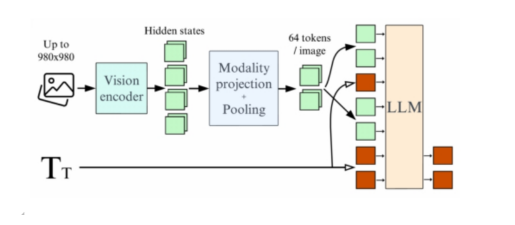

Question: <DocVQA>The component on the far right in the picture.
Answer: LLM


In [18]:
from transformers import AutoModelForCausalLM, AutoProcessor, AutoConfig  
import torch  
from PIL import Image  
import matplotlib.pyplot as plt  
  
# 加载配置、模型和处理器  
config = AutoConfig.from_pretrained("/root/models/florence2", trust_remote_code=True)  
if config.vision_config.model_type != 'davit':  
    config.vision_config.model_type = 'davit'  
  
model = AutoModelForCausalLM.from_pretrained("/root/models/florence2", config=config, trust_remote_code=True)  
processor = AutoProcessor.from_pretrained("/root/models/florence2", trust_remote_code=True)  
  
# 设置设备  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)  
  
def prepare_inference_data(question, image_path):  
    image = Image.open(image_path).convert("RGB")  
    inputs = processor(text=[question], images=[image], return_tensors="pt", padding=True).to(device)  
    return inputs  
  
def infer(question, image_path):  
    model.eval()  
    inputs = prepare_inference_data(question, image_path)  
    with torch.no_grad():  
        outputs = model.generate(input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"], max_new_tokens=100)  
    answer = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)  
    return answer  
  
# 示例问题和图像路径  
question = "<DocVQA>The component on the far right in the picture."  
image_path = "/home/david/1.png"  
  
# 进行推理  
answer = infer(question, image_path)  
  
# 显示图片  
image = Image.open(image_path)  
plt.imshow(image)  
plt.axis('off')  # 关闭坐标轴  
plt.show()  
  
# 打印问题和答案  
print(f"Question: {question}")  
print(f"Answer: {answer}")  
